[View in Colaboratory](https://colab.research.google.com/github/alitk/DeepRL-RRM/blob/master/WSPmin.ipynb)

In [19]:
import pdb
import math 
import numpy as np
from math import sqrt
class comm_channel:
    #this class is with assumption of power equal to 1 watts for all users. 

    p=1
    c=3e8
    def __init__(self,sigma2dBmHz=-173.9,B=180e3,cell_radius=3e3,freq=900e6,
               BW=10e6,path_loss_exponent=3,packet_length=10e3,CSI_mu=1,
               num_UE=5,num_MTD=5,packet_size=1e3):
        self.num_UE=num_UE
        self.num_MTD=num_MTD
        self.num_users=num_MTD+num_UE
        self.sigma2dBmHz=sigma2dBmHz # noise variance in dBm/Hz
        self.B=B #RB BW
        self.cell_radius=cell_radius # Downlink cell radius
        self.freq=freq # working frequency
        self.BW=BW #bandwidth
        self.path_loss_exponent=path_loss_exponent
        self.packet_length=packet_length
        self.num_RB=math.floor(BW/B); #Number of Resource blocks
        self.CSI_mu=CSI_mu  # channel gains hij^2 are exponential with mean CSI_mu.
        self.W=np.ones((self.num_users,1));
        self.hij=np.random.exponential(scale=1.0,size=(self.num_users,
                                                       self.num_RB))
        self.packet_size=packet_size



    def create(self):
        channel_wavelength=self.c/self.freq
        sigma2dBm=self.sigma2dBmHz+10*math.log10(self.B)
        sigma2=10**(sigma2dBm/10)*1e-3 # sigma 2 in Watts
        bound=np.ones((self.num_users,1))*self.cell_radius/2
        # this is for a squared shape cell
        x=np.random.uniform(-bound,+bound)
        y=np.random.uniform(-bound,+bound)
        d=np.sqrt(np.power(x,2)+np.power(y,2))
        path_loss=(channel_wavelength/(4*math.pi))**2*np.power(d,-self.path_loss_exponent)
        self.cij=np.diag(path_loss.T.squeeze())@self.hij/sigma2 # rate is equal to math.log((1+cij),2_)
        self.rates=np.squeeze(self.B*np.log2(1+self.p*self.cij))
        self.packet_rates=self.rates/self.packet_size
  


    def Recursive_eval_WSPmin(self,lambda_el,arrival_rate):

        constant=np.divide(self.B,self.W)*lambda_el/np.log(2)
        constant_Matrix=np.tile(constant, (1,self.num_RB))
        lambda_matrix=np.tile(lambda_el, (1,self.num_RB))
        W_matrix=np.tile(self.W, (1,self.num_RB))

        pij_eval=np.maximum(constant_Matrix-1/self.cij,0)
        g_j_lambda=W_matrix*pij_eval-lambda_matrix*(self.B*np.log2(1+pij_eval*self.cij))
        m=np.amin(g_j_lambda,axis=0)
        I=np.argmin(g_j_lambda,axis=0)
        g_labmda=0
        pij=np.zeros(self.cij.shape)
        for j in range(0,self.num_RB):
            pij[I[j],j]=pij_eval[I[j],j]
            g_labmda=g_labmda+m[j]
        
            
            

        y=g_labmda+lambda_el*arrival_rate
        


        return y,pij



    def maximize_lambda_ellipsoid_WSPmin(self,arrival_rate,pij,lambda_el,
                                        P_eig=2e3):
        
        """
            P: is the vvalue of eigenvalues of initial ellipsoids. 
            lambda_el is the ellipsoid lambda.
            cij: a mixture of channel gain path loss and channel noise

        """
        n=np.size(pij,0)
        P=P_eig*np.identity(n) # this is initial ellipsoid
        users_rate=np.sum((self.B*np.log2(1+pij*self.cij)),axis=1)
        users_rate=np.expand_dims(users_rate,axis=1)
        g=users_rate-arrival_rate
        c=0
        Data=np.array([])
        while sqrt((g.T@P@g)[0][0])>1e-5:
            out,pij=self.Recursive_eval_WSPmin(lambda_el,arrival_rate)
            users_rate=np.sum((self.B*np.log2(1+pij*self.cij)),axis=1)
            users_rate=np.expand_dims(users_rate,axis=1)
            g=users_rate-arrival_rate
            gT=g/sqrt(g.T@P@g)
            lambda_el=lambda_el-1/(n+1)*P@gT
            lambda_el=np.maximum(lambda_el,0)
            P=n**2/(n**2-1)*(P-2/(n+1)*P@gT@gT.T@P)
            c=c+1
            
            
              
            Data=np.append(Data,lambda_el)
            
        
        return lambda_el,pij,Data

        





array([1056754.14600974, 1007226.09337116, 1002124.57730758,
        989563.08430028,  954567.25337328, 1001026.8070249 ,
       1000759.78275033, 1085499.05249501,  912925.52579402,
        972196.33412779])

In [0]:
a=comm_channel()
a.create()
arrival_rate=1e6*np.ones((a.num_users,1))
lambda_el=np.zeros((a.num_users,1))
pij=np.zeros(a.cij.shape)
lambda_el=1/3
lambda_el,pij,Data=a.maximize_lambda_ellipsoid_WSPmin(arrival_rate,pij,lambda_el);

#y,pij=a.Recursive_eval_WSPmin(lambda_el,arrival_rate)
np.sum(pij,axis=1)
users_rate=np.sum((a.B*np.log2(1+pij*a.cij)),axis=1)


1859.00195714651

(51860,)

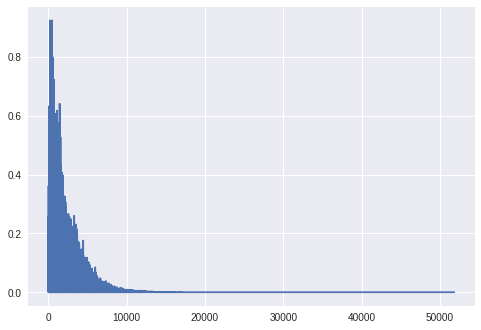

In [10]:
from matplotlib import pyplot as plt
plt.plot(Data)
min(Data)
Data.shape